In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
import scipy
%matplotlib inline

X, y = make_classification(n_samples=1000000, n_features=10, n_redundant=3, n_repeated=2, 
                           n_informative=5, n_clusters_per_class=4, 
                           random_state=42) #for reproducibility 

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
def dist(x,y):
    return np.linalg.norm(x-y)
    #return scipy.spatial.distance.correlation(x,y)

def poprow(arr,i):
    pop = arr[i]
    new_array = np.vstack((arr[:i],arr[i+1:]))
    return new_array,pop

def cluster(X, p, k, dist_to_xr):
    #c = [p]
    #D = np.column_stack((X,[dist(v[:-1],p[:-1]) for v in X]))
    #D = D[D[:,-1].argsort()]
    #D = np.delete(D, -1, 1)
    #c.extend(D[:k-1])
    #D = D[k-1:]

    #xc = np.array([p[:-1] for p in c], copy=False, ndmin=2)
    #yc = np.array([p[-1] for p in c], copy=False)
    #cl = (xc, yc)
    #return D, cl

    c = [p]
    
    if dist_to_xr == None:
        distances = [dist(v[:-1],p[:-1]) for v in X]
    else:
        distances = dist_to_xr
        
    X = X[np.argpartition(distances, k-1)]
    c.extend(X[:k-1])
    X = X[k-1:]
    
    xc = np.array([p[:-1] for p in c], copy=False, ndmin=2)
    yc = np.array([p[-1] for p in c], copy=False)
    cl = (xc, yc)
    
    return X, cl
    
def mdav(X, y, k):
    D = np.column_stack((X,y))
    clusters = []
    while len(D) >= 3*k:
        # Centroid
        xm = np.mean(D, axis=0)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])
        D, xr = poprow(D, xri)
        # Furthest from furthest from centroid
        dist_to_xr = [dist(v[:-1],xr[:-1]) for v in D]
        xsi = np.argmax(dist_to_xr)
        dist_to_xr = dist_to_xr[:xsi]+dist_to_xr[xsi+1:]
        D, xs = poprow(D, xsi) 

        #cluster of xr
        D, c = cluster(D, xr, k, dist_to_xr)
        clusters.append(c)
        #cluster of xs
        D, c = cluster(D, xs, k, None)
        clusters.append(c)
        
    if len(D) >= 2*k and len(D) < 3*k:
        # Centroid
        xm = np.mean(D, axis=0)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])
        D, xr = poprow(D, xri)
        #cluster of xr
        D, c = cluster(D, xr, k, None)
        clusters.append(c)
        
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)     
    else:
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)
    
    centroids = np.array([np.mean(c[0],axis=0) for c in clusters], copy=False)
    
    return clusters, centroids

from sklearn import tree
def gen_explanations(clustering, max_depth=-1):
    explanations = []
    for cluster in clustering:
        # Testing with max depth
        if max_depth < 1:
            exp = tree.DecisionTreeClassifier()
        else:
            exp = tree.DecisionTreeClassifier(max_depth=max_depth)
        exp.fit(cluster[0],cluster[1])
        explanations.append(exp) 
    return explanations

def pre_explanations(explanations, centroids, X):
    predictions = []
    for sample in X:
        #select the closest classifier
        exp = explanations[np.argmin([dist(sample,c) for c in centroids])]
        exp_pred = exp.predict([sample])
        predictions.append(int(exp_pred[0]))
    return predictions

def pre_explanations_ext(explanations, centroids, X, T, n):
    predictions_first = []
    predictions_guided = []
    ret_exp = []
    ret_cen = []
    for sample, truth in zip(X,T):
        #select the 3 closest classifiers
        mins = np.array([dist(sample,c) for c in centroids]).argsort()[:n]
        for m in mins:
            exp = explanations[m]
            exp_pred = exp.predict([sample])
            if(exp_pred[0] == truth):
                break
        predictions_first.append(int(explanations[mins[0]].predict([sample])[0]))
        predictions_guided.append(exp_pred[0])
        ret_exp.append(exp)
        ret_cen.append(centroids[m])
    return predictions_first, predictions_guided, ret_exp, ret_cen

In [4]:
import time
exec_times = []

# Generate clusters for different representativities
representativity = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
#representativity = [0.05]
K = [int(len(X_train)*r) for r in representativity]
clusterings = []
centroids_of_clusterings = []
for k in K:
    start = time.time()

    clustering, centroids = mdav(X_train, y_train, k)
    clusterings.append(clustering)
    centroids_of_clusterings.append(centroids)  
    
    end = time.time()
    exec_times.append(end-start)
    display(f'Time for k={k}: {end-start} seconds.')

'Time for k=670: 900.2986648082733 seconds.'

'Time for k=3350: 181.25359892845154 seconds.'

'Time for k=6700: 91.80210781097412 seconds.'

'Time for k=33500: 19.79706358909607 seconds.'

'Time for k=67000: 10.378959655761719 seconds.'

'Time for k=100500: 7.102719306945801 seconds.'

'Time for k=134000: 5.709556341171265 seconds.'

'Time for k=167500: 4.91295051574707 seconds.'

'Time for k=201000: 3.5619888305664062 seconds.'

In [5]:
print(exec_times)

[900.2986648082733, 181.25359892845154, 91.80210781097412, 19.79706358909607, 10.378959655761719, 7.102719306945801, 5.709556341171265, 4.91295051574707, 3.5619888305664062]


In [6]:
from tqdm import tqdm
shallow=True
clu_explanations = []
for clustering in tqdm(clusterings):
    # Test with shallow trees depht=4
    if shallow:
        explanations = gen_explanations(clustering, 4)
    else:
        explanations = gen_explanations(clustering, -1)
    clu_explanations.append(explanations)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 11%|█████████▎                                                                          | 1/9 [00:02<00:17,  2.14s/it]

 22%|██████████████████▋                                                                 | 2/9 [00:04<00:15,  2.26s/it]

 33%|████████████████████████████                                                        | 3/9 [00:06<00:13,  2.32s/it]

 44%|█████████████████████████████████████▎                                              | 4/9 [00:09<00:12,  2.43s/it]

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:12<00:10,  2.55s/it]

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:15<00:07,  2.63s/it]

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:17<00:05,  2.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:20<00:02,  2.69s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.60s/it]

In [7]:
# Train blackbox model
from sklearn.neural_network import MLPClassifier
blackbox = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=1,  random_state=21,tol=0.000000001)
blackbox.fit(X_train, y_train)

Iteration 1, loss = 0.36259298


Iteration 2, loss = 0.24581898


Iteration 3, loss = 0.21294277


Iteration 4, loss = 0.19200301


Iteration 5, loss = 0.17568969


Iteration 6, loss = 0.16444348


Iteration 7, loss = 0.15690228


Iteration 8, loss = 0.15077435


Iteration 9, loss = 0.14606117


Iteration 10, loss = 0.14222201


Iteration 11, loss = 0.13912586


Iteration 12, loss = 0.13637242


Iteration 13, loss = 0.13414063


Iteration 14, loss = 0.13199409


Iteration 15, loss = 0.13024987


Iteration 16, loss = 0.12856054


Iteration 17, loss = 0.12700290


Iteration 18, loss = 0.12602104


Iteration 19, loss = 0.12463951


Iteration 20, loss = 0.12366419


Iteration 21, loss = 0.12262749


Iteration 22, loss = 0.12173496


Iteration 23, loss = 0.12085035


Iteration 24, loss = 0.12035285


Iteration 25, loss = 0.11947145


Iteration 26, loss = 0.11879139


Iteration 27, loss = 0.11831097


Iteration 28, loss = 0.11753188


Iteration 29, loss = 0.11700097


Iteration 30, loss = 0.11643785


Iteration 31, loss = 0.11635304


Iteration 32, loss = 0.11577817


Iteration 33, loss = 0.11525354


Iteration 34, loss = 0.11469211


Iteration 35, loss = 0.11459520


Iteration 36, loss = 0.11412329


Iteration 37, loss = 0.11366397


Iteration 38, loss = 0.11331989


Iteration 39, loss = 0.11315010


Iteration 40, loss = 0.11281850


Iteration 41, loss = 0.11245626


Iteration 42, loss = 0.11222543


Iteration 43, loss = 0.11191918


Iteration 44, loss = 0.11160288


Iteration 45, loss = 0.11132389


Iteration 46, loss = 0.11107693


Iteration 47, loss = 0.11085633


Iteration 48, loss = 0.11066306


Iteration 49, loss = 0.11053076


Iteration 50, loss = 0.11020027


Iteration 51, loss = 0.11006985


Iteration 52, loss = 0.10988650


Iteration 53, loss = 0.10965314


Iteration 54, loss = 0.10953571


Iteration 55, loss = 0.10932756


Iteration 56, loss = 0.10908394


Iteration 57, loss = 0.10919006


Iteration 58, loss = 0.10890215


Iteration 59, loss = 0.10884634


Iteration 60, loss = 0.10854266


Iteration 61, loss = 0.10838678


Iteration 62, loss = 0.10814638


Iteration 63, loss = 0.10821822


Iteration 64, loss = 0.10804889


Iteration 65, loss = 0.10793261


Iteration 66, loss = 0.10781369


Iteration 67, loss = 0.10771974


Iteration 68, loss = 0.10729616


Iteration 69, loss = 0.10726836


Iteration 70, loss = 0.10723335


Iteration 71, loss = 0.10716960


Iteration 72, loss = 0.10719286


Iteration 73, loss = 0.10693409


Iteration 74, loss = 0.10686782


Iteration 75, loss = 0.10668666


Iteration 76, loss = 0.10650705


Iteration 77, loss = 0.10653841


Iteration 78, loss = 0.10638778


Iteration 79, loss = 0.10631184


Iteration 80, loss = 0.10610827


Iteration 81, loss = 0.10596939


Iteration 82, loss = 0.10612095


Iteration 83, loss = 0.10593988


Iteration 84, loss = 0.10585880


Iteration 85, loss = 0.10584615


Iteration 86, loss = 0.10564806


Iteration 87, loss = 0.10556013


Iteration 88, loss = 0.10557328


Iteration 89, loss = 0.10542722


Iteration 90, loss = 0.10550672


Iteration 91, loss = 0.10523612


Iteration 92, loss = 0.10518362


Iteration 93, loss = 0.10511485


Iteration 94, loss = 0.10505220


Iteration 95, loss = 0.10487028


Iteration 96, loss = 0.10477499


Iteration 97, loss = 0.10491320


Iteration 98, loss = 0.10486799


Iteration 99, loss = 0.10463104


Iteration 100, loss = 0.10491016


Iteration 101, loss = 0.10461250


Iteration 102, loss = 0.10459748


Iteration 103, loss = 0.10447503


Iteration 104, loss = 0.10444726


Iteration 105, loss = 0.10442689


Iteration 106, loss = 0.10427292


Iteration 107, loss = 0.10414625


Iteration 108, loss = 0.10424991


Iteration 109, loss = 0.10413696


Iteration 110, loss = 0.10411886


Iteration 111, loss = 0.10408506


Iteration 112, loss = 0.10401614


Iteration 113, loss = 0.10396528


Iteration 114, loss = 0.10396363


Iteration 115, loss = 0.10391188


Iteration 116, loss = 0.10388750


Iteration 117, loss = 0.10377185


Iteration 118, loss = 0.10364182


Iteration 119, loss = 0.10369277


Iteration 120, loss = 0.10353349


Iteration 121, loss = 0.10348006


Iteration 122, loss = 0.10363664


Iteration 123, loss = 0.10343873


Iteration 124, loss = 0.10322160


Iteration 125, loss = 0.10339527


Iteration 126, loss = 0.10334488


Iteration 127, loss = 0.10324248


Iteration 128, loss = 0.10329221


Iteration 129, loss = 0.10314715


Iteration 130, loss = 0.10311450


Iteration 131, loss = 0.10322686


Iteration 132, loss = 0.10306591


Iteration 133, loss = 0.10297292


Iteration 134, loss = 0.10305782


Iteration 135, loss = 0.10291970


Iteration 136, loss = 0.10290279


Iteration 137, loss = 0.10279795


Iteration 138, loss = 0.10285773


Iteration 139, loss = 0.10282791


Iteration 140, loss = 0.10285202


Iteration 141, loss = 0.10281354


Iteration 142, loss = 0.10266026


Iteration 143, loss = 0.10263599


Iteration 144, loss = 0.10252322


Iteration 145, loss = 0.10257898


Iteration 146, loss = 0.10252938


Iteration 147, loss = 0.10246226


Iteration 148, loss = 0.10251020


Iteration 149, loss = 0.10253200


Iteration 150, loss = 0.10245027


Iteration 151, loss = 0.10246229


Iteration 152, loss = 0.10232463


Iteration 153, loss = 0.10222629


Iteration 154, loss = 0.10246404


Iteration 155, loss = 0.10234825


Iteration 156, loss = 0.10220755


Iteration 157, loss = 0.10206512


Iteration 158, loss = 0.10209997


Iteration 159, loss = 0.10206116


Iteration 160, loss = 0.10207783


Iteration 161, loss = 0.10213594


Iteration 162, loss = 0.10207446


Iteration 163, loss = 0.10188175


Iteration 164, loss = 0.10197422


Iteration 165, loss = 0.10191427


Iteration 166, loss = 0.10198044


Iteration 167, loss = 0.10198537


Iteration 168, loss = 0.10189174


Iteration 169, loss = 0.10174038


Iteration 170, loss = 0.10171001


Iteration 171, loss = 0.10174402


Iteration 172, loss = 0.10173208


Iteration 173, loss = 0.10185181


Iteration 174, loss = 0.10172339


Iteration 175, loss = 0.10167668


Iteration 176, loss = 0.10157150


Iteration 177, loss = 0.10163842


Iteration 178, loss = 0.10155505


Iteration 179, loss = 0.10153860


Iteration 180, loss = 0.10151731


Iteration 181, loss = 0.10158315


Iteration 182, loss = 0.10149351


Iteration 183, loss = 0.10141938


Iteration 184, loss = 0.10135028


Iteration 185, loss = 0.10138507


Iteration 186, loss = 0.10136023


Iteration 187, loss = 0.10132208


Iteration 188, loss = 0.10140618


Iteration 189, loss = 0.10128054


Iteration 190, loss = 0.10129985


Iteration 191, loss = 0.10130181


Iteration 192, loss = 0.10107698


Iteration 193, loss = 0.10115174


Iteration 194, loss = 0.10124183


Iteration 195, loss = 0.10113185


Iteration 196, loss = 0.10119546


Iteration 197, loss = 0.10101427


Iteration 198, loss = 0.10100095


Iteration 199, loss = 0.10097494


Iteration 200, loss = 0.10109091


Iteration 201, loss = 0.10100063


Iteration 202, loss = 0.10095519


Iteration 203, loss = 0.10087000


Iteration 204, loss = 0.10092507


Iteration 205, loss = 0.10095814


Iteration 206, loss = 0.10088105


Iteration 207, loss = 0.10089603


Iteration 208, loss = 0.10085980


Iteration 209, loss = 0.10077195


Iteration 210, loss = 0.10079509


Iteration 211, loss = 0.10090962


Iteration 212, loss = 0.10065830


Iteration 213, loss = 0.10068099


Iteration 214, loss = 0.10067975


Iteration 215, loss = 0.10058758


Iteration 216, loss = 0.10074769


Iteration 217, loss = 0.10079139


Iteration 218, loss = 0.10067453


Iteration 219, loss = 0.10062749


Iteration 220, loss = 0.10057203


Iteration 221, loss = 0.10050347


Iteration 222, loss = 0.10055300


Iteration 223, loss = 0.10046498


Iteration 224, loss = 0.10054989


Iteration 225, loss = 0.10054008


Iteration 226, loss = 0.10043681


Iteration 227, loss = 0.10039089


Iteration 228, loss = 0.10040507


Iteration 229, loss = 0.10037267


Iteration 230, loss = 0.10042847


Iteration 231, loss = 0.10022837


Iteration 232, loss = 0.10027186


Iteration 233, loss = 0.10033820


Iteration 234, loss = 0.10029703


Iteration 235, loss = 0.10011811


Iteration 236, loss = 0.10020856


Iteration 237, loss = 0.10043942


Iteration 238, loss = 0.10013326


Iteration 239, loss = 0.10016885


Iteration 240, loss = 0.10027200


Iteration 241, loss = 0.10018234


Iteration 242, loss = 0.10014810


Iteration 243, loss = 0.10010592


Iteration 244, loss = 0.10022582


Iteration 245, loss = 0.10012212


Iteration 246, loss = 0.09999794


Iteration 247, loss = 0.10006274


Iteration 248, loss = 0.10000846


Iteration 249, loss = 0.10002498


Iteration 250, loss = 0.09999979


Iteration 251, loss = 0.09999899


Iteration 252, loss = 0.09995366


Iteration 253, loss = 0.09995198


Iteration 254, loss = 0.09997090


Iteration 255, loss = 0.09999350


Iteration 256, loss = 0.10000196


Iteration 257, loss = 0.09983690


Iteration 258, loss = 0.09989858


Iteration 259, loss = 0.09987614


Iteration 260, loss = 0.09979602


Iteration 261, loss = 0.09987740


Iteration 262, loss = 0.09986170


Iteration 263, loss = 0.09993682


Iteration 264, loss = 0.09977865


Iteration 265, loss = 0.09975587


Iteration 266, loss = 0.09969543


Iteration 267, loss = 0.09971659


Iteration 268, loss = 0.09962320


Iteration 269, loss = 0.09965901


Iteration 270, loss = 0.09971654


Iteration 271, loss = 0.09974325


Iteration 272, loss = 0.09971123


Iteration 273, loss = 0.09963630


Iteration 274, loss = 0.09960098


Iteration 275, loss = 0.09971217


Iteration 276, loss = 0.09959604


Iteration 277, loss = 0.09959626


Iteration 278, loss = 0.09962300


Iteration 279, loss = 0.09958740


Iteration 280, loss = 0.09963160


Iteration 281, loss = 0.09954049


Iteration 282, loss = 0.09962882


Iteration 283, loss = 0.09950885


Iteration 284, loss = 0.09954923


Iteration 285, loss = 0.09945867


Iteration 286, loss = 0.09943248


Iteration 287, loss = 0.09942717


Iteration 288, loss = 0.09958820


Iteration 289, loss = 0.09944546


Iteration 290, loss = 0.09943069


Iteration 291, loss = 0.09936197


Iteration 292, loss = 0.09935238


Iteration 293, loss = 0.09943162


Iteration 294, loss = 0.09930318


Iteration 295, loss = 0.09926506


Iteration 296, loss = 0.09930416


Iteration 297, loss = 0.09926479


Iteration 298, loss = 0.09935835


Iteration 299, loss = 0.09931055


Iteration 300, loss = 0.09934991


Iteration 301, loss = 0.09926424


Iteration 302, loss = 0.09928555


Iteration 303, loss = 0.09915013


Iteration 304, loss = 0.09919810


Iteration 305, loss = 0.09918177


Iteration 306, loss = 0.09925362


Iteration 307, loss = 0.09926148


Iteration 308, loss = 0.09917194


Iteration 309, loss = 0.09922788


Iteration 310, loss = 0.09912019


Iteration 311, loss = 0.09909310


Iteration 312, loss = 0.09913475


Iteration 313, loss = 0.09899679


Iteration 314, loss = 0.09908957


Iteration 315, loss = 0.09920054


Iteration 316, loss = 0.09906700


Iteration 317, loss = 0.09903439


Iteration 318, loss = 0.09907334


Iteration 319, loss = 0.09903400


Iteration 320, loss = 0.09888489


Iteration 321, loss = 0.09900116


Iteration 322, loss = 0.09902213


Iteration 323, loss = 0.09886626


Iteration 324, loss = 0.09907230


Iteration 325, loss = 0.09897776


Iteration 326, loss = 0.09892850


Iteration 327, loss = 0.09889850


Iteration 328, loss = 0.09888255


Iteration 329, loss = 0.09893120


Iteration 330, loss = 0.09887706


Iteration 331, loss = 0.09889139


Iteration 332, loss = 0.09892548


Iteration 333, loss = 0.09887209


Iteration 334, loss = 0.09880997


Iteration 335, loss = 0.09883251


Iteration 336, loss = 0.09878246


Iteration 337, loss = 0.09876240


Iteration 338, loss = 0.09887916


Iteration 339, loss = 0.09883580


Iteration 340, loss = 0.09885433


Iteration 341, loss = 0.09876733


Iteration 342, loss = 0.09872378


Iteration 343, loss = 0.09878707


Iteration 344, loss = 0.09874620


Iteration 345, loss = 0.09870236


Iteration 346, loss = 0.09875572


Iteration 347, loss = 0.09872843


Iteration 348, loss = 0.09871100


Iteration 349, loss = 0.09874790


Iteration 350, loss = 0.09862461


Iteration 351, loss = 0.09858992


Iteration 352, loss = 0.09867693


Iteration 353, loss = 0.09867354


Iteration 354, loss = 0.09871385


Iteration 355, loss = 0.09866236


Iteration 356, loss = 0.09859484


Iteration 357, loss = 0.09856944


Iteration 358, loss = 0.09856844


Iteration 359, loss = 0.09856072


Iteration 360, loss = 0.09858650


Iteration 361, loss = 0.09849957


Iteration 362, loss = 0.09851503


Iteration 363, loss = 0.09848998


Iteration 364, loss = 0.09854572


Iteration 365, loss = 0.09847612


Iteration 366, loss = 0.09845562


Iteration 367, loss = 0.09848891


Iteration 368, loss = 0.09849799


Iteration 369, loss = 0.09855424


Iteration 370, loss = 0.09842961


Iteration 371, loss = 0.09833555


Iteration 372, loss = 0.09842777


Iteration 373, loss = 0.09843063


Iteration 374, loss = 0.09840057


Iteration 375, loss = 0.09841022


Iteration 376, loss = 0.09838219


Iteration 377, loss = 0.09845303


Iteration 378, loss = 0.09832421


Iteration 379, loss = 0.09841766


Iteration 380, loss = 0.09832418


Iteration 381, loss = 0.09844293


Iteration 382, loss = 0.09838797


Iteration 383, loss = 0.09832672


Iteration 384, loss = 0.09817525


Iteration 385, loss = 0.09825151


Iteration 386, loss = 0.09826668


Iteration 387, loss = 0.09826290


Iteration 388, loss = 0.09825982


Iteration 389, loss = 0.09829675


Iteration 390, loss = 0.09834481


Iteration 391, loss = 0.09824257


Iteration 392, loss = 0.09824268


Iteration 393, loss = 0.09821235


Iteration 394, loss = 0.09835299


Iteration 395, loss = 0.09813144


Iteration 396, loss = 0.09825553


Iteration 397, loss = 0.09816468


Iteration 398, loss = 0.09817250


Iteration 399, loss = 0.09816189


Iteration 400, loss = 0.09808398


Iteration 401, loss = 0.09815603


Iteration 402, loss = 0.09810005


Iteration 403, loss = 0.09801372


Iteration 404, loss = 0.09816839


Iteration 405, loss = 0.09823356


Iteration 406, loss = 0.09816779


Iteration 407, loss = 0.09816003


Iteration 408, loss = 0.09816524


Iteration 409, loss = 0.09807383


Iteration 410, loss = 0.09803007


Iteration 411, loss = 0.09810423


Iteration 412, loss = 0.09804714


Iteration 413, loss = 0.09800076


Iteration 414, loss = 0.09799020


Iteration 415, loss = 0.09799661


Iteration 416, loss = 0.09801916


Iteration 417, loss = 0.09795562


Iteration 418, loss = 0.09800317


Iteration 419, loss = 0.09792241


Iteration 420, loss = 0.09800340


Iteration 421, loss = 0.09790850


Iteration 422, loss = 0.09792908


Iteration 423, loss = 0.09801134


Iteration 424, loss = 0.09788190


Iteration 425, loss = 0.09789753


Iteration 426, loss = 0.09792055


Iteration 427, loss = 0.09786085


Iteration 428, loss = 0.09790888


Iteration 429, loss = 0.09788421


Iteration 430, loss = 0.09792666


Iteration 431, loss = 0.09789951


Iteration 432, loss = 0.09787856


Iteration 433, loss = 0.09785115


Iteration 434, loss = 0.09795210


Iteration 435, loss = 0.09777122


Iteration 436, loss = 0.09785339


Iteration 437, loss = 0.09782776


Iteration 438, loss = 0.09782666


Iteration 439, loss = 0.09788381


Iteration 440, loss = 0.09780561


Iteration 441, loss = 0.09786839


Iteration 442, loss = 0.09783273


Iteration 443, loss = 0.09788175


Iteration 444, loss = 0.09780983


Iteration 445, loss = 0.09765688


Iteration 446, loss = 0.09775716


Iteration 447, loss = 0.09768727


Iteration 448, loss = 0.09769411


Iteration 449, loss = 0.09775937


Iteration 450, loss = 0.09770527


Iteration 451, loss = 0.09773533


Iteration 452, loss = 0.09783320


Iteration 453, loss = 0.09778762


Iteration 454, loss = 0.09774860


Iteration 455, loss = 0.09772172


Iteration 456, loss = 0.09769018
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.


MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=21,
              solver='sgd', tol=1e-09, verbose=1)

In [8]:
#Train big tree
surrogate = tree.DecisionTreeClassifier()
surrogate.fit(X_train,y_train)
display(surrogate.score(X_test, y_test))
display(surrogate.tree_.node_count)

0.9188181818181819

71581

In [9]:
display(surrogate.get_depth())

56

In [10]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(surrogate, out_file=dot_data,  
                filled=True, rounded=True, #feature_names=labels, class_names=['below 50K', 'over 50K'],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
display(Image(graph.create_png()))

ModuleNotFoundError: No module named 'sklearn.externals.six'

In [13]:
truth = y_test
blackbox_predictions = blackbox.predict(X_test)
surrogate_predictions = surrogate.predict(X_test)

In [24]:
from tqdm import tqdm

explanation_predictions = []
explanation_ext_predictions = []
for i in tqdm(range(len(clu_explanations))):
    #p = pre_explanations(clu_explanations[i], centroids_of_clusterings[i], X_test)
    p,q,_,_ = pre_explanations_ext(clu_explanations[i], centroids_of_clusterings[i], X_test, blackbox_predictions, 3)
    explanation_predictions.append(p)
    explanation_ext_predictions.append(q)



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 11%|████████▉                                                                       | 1/9 [51:44<6:53:57, 3104.74s/it]

 22%|█████████████████▎                                                            | 2/9 [1:04:08<4:39:36, 2396.59s/it]

 33%|██████████████████████████                                                    | 3/9 [1:10:45<2:59:38, 1796.49s/it]

 44%|██████████████████████████████████▋                                           | 4/9 [1:12:58<1:48:07, 1297.57s/it]

 56%|███████████████████████████████████████████▉                                   | 5/9 [1:14:35<1:02:29, 937.27s/it]

 67%|██████████████████████████████████████████████████████                           | 6/9 [1:16:00<34:05, 681.70s/it]

 78%|███████████████████████████████████████████████████████████████                  | 7/9 [1:17:25<16:45, 502.53s/it]

 89%|█████████████████████████

In [25]:
# acc = TP+TN/all
acc_blackbox = np.mean([t==p for t,p in zip(truth, blackbox_predictions)])
acc_surrogate = np.mean([t==p for t,p in zip(truth, surrogate_predictions)])
acc_explanations = []
for i in range(len(explanation_predictions)):
    acc_explanations.append(np.mean([t==p for t,p in zip(truth, explanation_predictions[i])]))
    
acc_explanations_ext = []
for i in range(len(explanation_ext_predictions)):
    acc_explanations_ext.append(np.mean([t==p for t,p in zip(truth, explanation_ext_predictions[i])]))

acc_cross = []
for i in range(len(explanation_predictions)):
    acc_cross.append(np.mean([t==p for t,p in zip(blackbox_predictions, explanation_predictions[i])]))

acc_cross_ext = []
for i in range(len(explanation_predictions)):
    acc_cross_ext.append(np.mean([t==p for t,p in zip(blackbox_predictions, explanation_ext_predictions[i])]))

display(acc_blackbox)
display(acc_surrogate)
display(acc_explanations)
display(acc_explanations_ext)
display(acc_cross)
display(acc_cross_ext)

0.9655303030303031

0.9191363636363636

[0.9198454545454545,
 0.9084727272727273,
 0.8988727272727273,
 0.8608636363636364,
 0.8543545454545455,
 0.8249575757575758,
 0.8255666666666667,
 0.8289787878787879,
 0.8277727272727273]

[0.9574939393939393,
 0.9528454545454546,
 0.9505090909090909,
 0.9438272727272727,
 0.9369181818181819,
 0.9218878787878788,
 0.9219454545454545,
 0.9225333333333333,
 0.9290151515151515]

[0.9339636363636363,
 0.9214878787878787,
 0.9107181818181819,
 0.8681090909090909,
 0.8620848484848485,
 0.8304212121212121,
 0.8306363636363636,
 0.8350666666666666,
 0.8319454545454545]

[0.9854121212121212,
 0.9790181818181818,
 0.9763363636363637,
 0.9691333333333333,
 0.9600121212121212,
 0.9440787878787879,
 0.9433787878787879,
 0.9443909090909091,
 0.9523212121212121]

In [26]:
min_nodes = []
max_nodes = []
mean_nodes = []
median_nodes = []
n_counts = []
for explanations in clu_explanations:
    node_counts = [exp.tree_.node_count for exp in explanations]
    n_counts.append(node_counts)
    min_nodes.append(np.min(node_counts))
    max_nodes.append(np.max(node_counts))
    mean_nodes.append(np.mean(node_counts))
    median_nodes.append(np.median(node_counts))

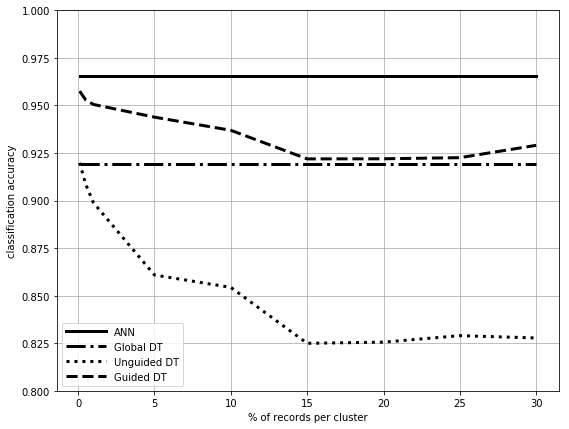

In [27]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

representativity = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
representativity = list([r*100 for r in representativity])
representativity = representativity

xnew = np.linspace(min(representativity),max(representativity),300)
spl = make_interp_spline(representativity, acc_explanations, k=3) #BSpline object
ynew = spl(xnew)

spl = make_interp_spline(representativity, acc_explanations_ext, k=3) #BSpline object
ynew4 = spl(xnew)

acc_blackbox_const = [acc_blackbox]*len(representativity)
spl = make_interp_spline(representativity, acc_blackbox_const, k=3) #BSpline object
ynew2 = spl(xnew)

big_tree = [acc_surrogate]*len(representativity)
spl = make_interp_spline(representativity, big_tree, k=3) #BSpline object
ynew6 = spl(xnew)

spl = make_interp_spline(representativity, acc_cross, k=3) #BSpline object
ynew3 = spl(xnew)

spl = make_interp_spline(representativity, acc_cross_ext, k=3) #BSpline object
ynew5 = spl(xnew)

spl = make_interp_spline(representativity, exec_times, k=3)
ynew7 = spl(xnew)

plt.figure(figsize=(9,7))
#plt.plot(xnew,ynew2,linestyle='-',linewidth=3,color='k',label='ANN')
#plt.plot(xnew,ynew6,linestyle='-.',linewidth=3,color='k',label='Global DT')
#plt.plot(xnew,ynew,linestyle=':',linewidth=3,color='k',label='Unguided DT')
#plt.plot(xnew,ynew4,linestyle='--',linewidth=3,color='k',label='Guided DT')

plt.plot(representativity,acc_blackbox_const,linestyle='-',linewidth=3,color='k',label='ANN')
plt.plot(representativity,big_tree,linestyle='-.',linewidth=3,color='k',label='Global DT')
plt.plot(representativity,acc_explanations,linestyle=':',linewidth=3,color='k',label='Unguided DT')
plt.plot(representativity,acc_explanations_ext,linestyle='--',linewidth=3,color='k',label='Guided DT')

plt.legend(handlelength=4)
plt.ylim(0.8,1)
plt.xlabel('% of records per cluster')
plt.ylabel('classification accuracy')
plt.grid()
plt.show()
plt.close()

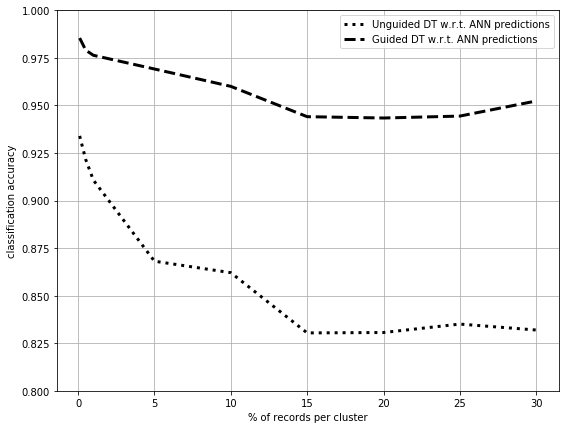

In [28]:
plt.figure(figsize=(9,7))
#plt.plot(xnew,ynew3,linestyle='-',linewidth=3,color='k',label='Unguided DT w.r.t. ANN predictions')
#plt.plot(xnew,ynew5,linestyle=':',linewidth=3,color='k',label='Guided DT w.r.t. ANN predictions')

plt.plot(representativity,acc_cross,linestyle=':',linewidth=3,color='k',label='Unguided DT w.r.t. ANN predictions')
plt.plot(representativity,acc_cross_ext,linestyle='--',linewidth=3,color='k',label='Guided DT w.r.t. ANN predictions')

plt.legend()
plt.ylim(0.8,1)
plt.xlabel('% of records per cluster')
plt.ylabel('classification accuracy')
plt.grid()
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(9,7))
plt.boxplot(n_counts[:9])
locs, _ = plt.xticks()
plt.xticks(locs, representativity)
if not shallow:
    plt.yscale('log')
    plt.ylabel('number of nodes (log scale)')
else:
    plt.ylabel('number of nodes')

plt.xlabel('% of records per cluster')
plt.grid()
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(representativity,exec_times,linestyle='-',linewidth=3,color='k')

plt.legend()
plt.xlabel('% of records per cluster')
plt.ylabel('execution time (s)')
plt.grid()
plt.show()
plt.close()